In [1]:
import pandas as pd 
from sklearn.utils import class_weight
from tqdm import tqdm

In [2]:
df = pd.read_csv('/run/media/twoaday/data-storag/data-sets/fashion-product-images-small/styles.csv', error_bad_lines=False)
df = df.dropna()

b'Skipping line 6044: expected 10 fields, saw 11\nSkipping line 6569: expected 10 fields, saw 11\nSkipping line 7399: expected 10 fields, saw 11\nSkipping line 7939: expected 10 fields, saw 11\nSkipping line 9026: expected 10 fields, saw 11\nSkipping line 10264: expected 10 fields, saw 11\nSkipping line 10427: expected 10 fields, saw 11\nSkipping line 10905: expected 10 fields, saw 11\nSkipping line 11373: expected 10 fields, saw 11\nSkipping line 11945: expected 10 fields, saw 11\nSkipping line 14112: expected 10 fields, saw 11\nSkipping line 14532: expected 10 fields, saw 11\nSkipping line 15076: expected 10 fields, saw 12\nSkipping line 29906: expected 10 fields, saw 11\nSkipping line 31625: expected 10 fields, saw 11\nSkipping line 33020: expected 10 fields, saw 11\nSkipping line 35748: expected 10 fields, saw 11\nSkipping line 35962: expected 10 fields, saw 11\nSkipping line 37770: expected 10 fields, saw 11\nSkipping line 38105: expected 10 fields, saw 11\nSkipping line 38275: ex

In [3]:
df.loc[df.usage == 'Smart Casual'].head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
1104,27870,Women,Apparel,Topwear,Shirts,White,Fall,2012.0,Smart Casual,Scullers For Her Women White Striped Shirt
4263,11324,Men,Apparel,Bottomwear,Trousers,Black,Fall,2011.0,Smart Casual,United Colors of Benetton Men Black and Brown ...
5860,20715,Men,Footwear,Shoes,Casual Shoes,Black,Winter,2018.0,Smart Casual,Red Tape Men Black Leather Casual Shoes
6440,59986,Women,Apparel,Dress,Dresses,Black,Fall,2012.0,Smart Casual,Avirate Women Black Dress
6486,46536,Men,Accessories,Watches,Watches,Black,Winter,2016.0,Smart Casual,Timex Men Black Dial Watch


In [4]:
df.groupby('usage').count()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,productDisplayName
usage,,,,,,,,,
Casual,34397,34397,34397,34397,34397,34397,34397,34397,34397
Ethnic,3208,3208,3208,3208,3208,3208,3208,3208,3208
Formal,2345,2345,2345,2345,2345,2345,2345,2345,2345
Home,1,1,1,1,1,1,1,1,1
Party,29,29,29,29,29,29,29,29,29
Smart Casual,67,67,67,67,67,67,67,67,67
Sports,4004,4004,4004,4004,4004,4004,4004,4004,4004
Travel,26,26,26,26,26,26,26,26,26


In [5]:
df.loc[df.usage == 'usage']

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName


In [6]:
classes = sorted(df.usage.unique())
weights = class_weight.compute_class_weight('balanced', classes, df.usage)
list(zip(classes, weights))

[('Casual', 0.16017748640869844),
 ('Ethnic', 1.7174641521197007),
 ('Formal', 2.3495202558635393),
 ('Home', 5509.625),
 ('Party', 189.98706896551724),
 ('Smart Casual', 82.23320895522389),
 ('Sports', 1.3760302197802199),
 ('Travel', 211.90865384615384)]

In [7]:
df.usage = df.usage.replace({'Smart Casual': 'Casual'})
df.usage = df.usage.replace({'Home': 'Other', 'Travel': 'Other', 'Party': 'Other'})
df.groupby('usage').count()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,productDisplayName
usage,,,,,,,,,
Casual,34464,34464,34464,34464,34464,34464,34464,34464,34464
Ethnic,3208,3208,3208,3208,3208,3208,3208,3208,3208
Formal,2345,2345,2345,2345,2345,2345,2345,2345,2345
Other,56,56,56,56,56,56,56,56,56
Sports,4004,4004,4004,4004,4004,4004,4004,4004,4004


In [8]:
classes = sorted(df.usage.unique())
weights = class_weight.compute_class_weight('balanced', classes, df.usage)
list(zip(classes, weights))

[('Casual', 0.255785747446611),
 ('Ethnic', 2.747942643391521),
 ('Formal', 3.759232409381663),
 ('Other', 157.41785714285714),
 ('Sports', 2.201648351648352)]

Using TensorFlow backend.


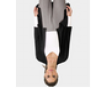

In [9]:
import matplotlib.image as mpimg
import imgaug.augmenters as iaa
import numpy as np

from keras.preprocessing import image
from commons.image_utils import scale_image

from PIL import Image

aug = iaa.Sequential([
        iaa.Crop(px=(0, 16)),  # crop images from each side by 0 to 16px (randomly chosen)
        iaa.Fliplr(0.5),  # horizontally flip 50% of the images
        iaa.Flipud(0.5),  # vertically flip 50% of the images
        iaa.GaussianBlur(sigma=(0., 2.))  # blur images with a sigma of 0 to 3.0
])

f = open('/run/media/twoaday/data-storag/data-sets/fashion-product-images-small/images/1165.jpg', 'rb')
f = Image.open(f)
f = scale_image(f, [96, 96])
f = np.asarray(f)
img_data = image.img_to_array(f)
img_data = np.expand_dims(img_data, axis=0)
img_data = img_data.astype('float32') / 255.
img_data = np.clip(img_data, 0., 1.)
img_data = img_data[0]
img_data = aug.augment_image(img_data)
# Creates PIL image
img = Image.fromarray(np.uint8(img_data * 255))
img

In [10]:
df.loc[df.masterCategory.isin(['Footwear','Apparel'])].groupby('baseColour').count().sort_values(by='id', ascending=False)

,id,gender,masterCategory,subCategory,articleType,season,year,usage,productDisplayName
baseColour,,,,,,,,,
Black,6125,6125,6125,6125,6125,6125,6125,6125,6125
White,4318,4318,4318,4318,4318,4318,4318,4318,4318
Blue,3980,3980,3980,3980,3980,3980,3980,3980,3980
Grey,2156,2156,2156,2156,2156,2156,2156,2156,2156
Brown,1901,1901,1901,1901,1901,1901,1901,1901,1901
Red,1810,1810,1810,1810,1810,1810,1810,1810,1810
Green,1666,1666,1666,1666,1666,1666,1666,1666,1666
Navy Blue,1545,1545,1545,1545,1545,1545,1545,1545,1545
Pink,1257,1257,1257,1257,1257,1257,1257,1257,1257


In [11]:
df.baseColour = df.baseColour.replace({'Lime Green': 'Green', 
                                       'Fluorescent Green': 'Green', 
                                       'Sea Green': 'Green',
                                       'Mushroom Brown':'Brown',
                                       'Coffee Brown':'Brown',
                                       'Bronze':'Brown',
                                       'Copper':'Brown',
                                       'Grey Melange':'Grey',
                                       'Rose': 'Red',
                                       'Burgundy':'Purple',
                                        'Metallic':'Grey',
                                       'Mustard':'Yellow',
                                        'Nude': 'Beige',
                                       'Gold':'Yellow',
                                       'Taupe': 'Grey',
                                       'Mauve':'Pink',
                                       'Steel':'Grey',
                                       'Turquoise Blue':'Blue',
                                       'Teal':'Blue',
                                       'Maroon':'Red',
                                       'Charcoal':'Grey',
                                       'Khaki':'Brown',
                                       'Navy Blue':'Blue',
                                       'Rust':'Orange',
                                       'Cream':'Yellow',
                                       'Peach':'Yellow',
                                       'Skin': 'Beige',
                                       'Tan': 'Beige',
                                       'Lavender':'Purple',
                                       'Magenta':'Purple',
                                      'Off White': 'White'})

df.groupby('baseColour').count().sort_values(by='id', ascending=False)

,id,gender,masterCategory,subCategory,articleType,season,year,usage,productDisplayName
baseColour,,,,,,,,,
Black,9700,9700,9700,9700,9700,9700,9700,9700,9700
Blue,6879,6879,6879,6879,6879,6879,6879,6879,6879
White,5679,5679,5679,5679,5679,5679,5679,5679,5679
Brown,3796,3796,3796,3796,3796,3796,3796,3796,3796
Grey,3476,3476,3476,3476,3476,3476,3476,3476,3476
Red,3032,3032,3032,3032,3032,3032,3032,3032,3032
Green,2135,2135,2135,2135,2135,2135,2135,2135,2135
Yellow,2063,2063,2063,2063,2063,2063,2063,2063,2063
Purple,1944,1944,1944,1944,1944,1944,1944,1944,1944


In [12]:
classes = sorted(df.baseColour.unique())
weights = class_weight.compute_class_weight('balanced', classes, df.baseColour)
list(zip(classes, weights))

[('Beige', 2.8227345501120715),
 ('Black', 0.3029347079037801),
 ('Blue', 0.4271648010854291),
 ('Brown', 0.7740955391640323),
 ('Green', 1.3763309914129587),
 ('Grey', 0.8453586497890295),
 ('Multi', 7.458037225042301),
 ('Olive', 7.184515077424613),
 ('Orange', 4.997392290249433),
 ('Pink', 1.5866450683945283),
 ('Purple', 1.511556927297668),
 ('Red', 0.9691512752858399),
 ('Silver', 2.6983164983164984),
 ('White', 0.5174267770147326),
 ('Yellow', 1.424365810308612)]

In [13]:
def category_extractor(row):
    if row['masterCategory'] == 'Personal Care':
        return 'Personal Care'
    if row['subCategory'] in ['Topwear', 'Dress', 'Headwear', 'Innerwear']:
        if len(df.loc[df.articleType == str(row['articleType'])]) >= 800:
            return str(row['articleType'])
    if row['subCategory'] in ['Bottomwear', 'Shoes'] and len(df.loc[df.articleType == str(row['articleType'])]) >= 300:
        return str(row['articleType'])
    return str(row['subCategory'])


df = df.loc[df.masterCategory != 'Sporting Goods']

exclude_list = ['Vouchers', 'Green', 'Home Furnishing', 'Umbrellas', 'Water Bottle', 'Bath and Body',
                    'Shoe Accessories', 'Sports Accessories', 'Sports Equipment', 'Free Gifts',
                    'Apparel Set']

for exclude in exclude_list:
    df = df.loc[df.subCategory != exclude]

tqdm.pandas()
df['subCategory'] = df.progress_apply(lambda row: category_extractor(row), axis=1)


df.subCategory = df.subCategory.replace({'Perfumes': 'Green',
                                             'Lips': 'Cosmetic',
                                             'Eyes': 'Cosmetic',
                                             'Wristbands': 'Accessories',
                                             'Cufflinks': 'Accessories',
                                             'Gloves': 'Accessories',
                                             'Sandals': 'Sandal',
                                             'Skin Care': 'Cosmetic',
                                             'Makeup': 'Cosmetic',
                                             'Skin': 'Cosmetic',
                                             'Hair': 'Cosmetic',
                                             'Nails': 'Cosmetic',
                                             'Beauty Accessories': 'Cosmetic',
                                             'Mufflers': 'Scarves',
                                             'Stoles': 'Scarves'
                                             })


df.groupby('subCategory').count().sort_values(by='id', ascending=False)

100%|██████████| 43811/43811 [01:06<00:00, 656.99it/s]


,id,gender,masterCategory,articleType,baseColour,season,year,usage,productDisplayName
subCategory,,,,,,,,,
Tshirts,7065,7065,7065,7065,7065,7065,7065,7065,7065
Shirts,3214,3214,3214,3214,3214,3214,3214,3214,3214
Bags,3053,3053,3053,3053,3053,3053,3053,3053,3053
Casual Shoes,2845,2845,2845,2845,2845,2845,2845,2845,2845
Watches,2542,2542,2542,2542,2542,2542,2542,2542,2542
Personal Care,2130,2130,2130,2130,2130,2130,2130,2130,2130
Sports Shoes,2016,2016,2016,2016,2016,2016,2016,2016,2016
Kurtas,1844,1844,1844,1844,1844,1844,1844,1844,1844
Tops,1762,1762,1762,1762,1762,1762,1762,1762,1762


In [14]:
df.loc[df.subCategory == 'Green'].sample()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
20016,36710,Men,Accessories,Green,Perfume and Body Mist,Red,Spring,2017.0,Casual,Ferrari Men Perfume


In [16]:
df = pd.read_csv('/run/media/twoaday/data-storag/data-sets/fashion-product-images-small/styles.csv', error_bad_lines=False)
df.groupby('masterCategory').count().sort_values(by='id', ascending=False)

b'Skipping line 6044: expected 10 fields, saw 11\nSkipping line 6569: expected 10 fields, saw 11\nSkipping line 7399: expected 10 fields, saw 11\nSkipping line 7939: expected 10 fields, saw 11\nSkipping line 9026: expected 10 fields, saw 11\nSkipping line 10264: expected 10 fields, saw 11\nSkipping line 10427: expected 10 fields, saw 11\nSkipping line 10905: expected 10 fields, saw 11\nSkipping line 11373: expected 10 fields, saw 11\nSkipping line 11945: expected 10 fields, saw 11\nSkipping line 14112: expected 10 fields, saw 11\nSkipping line 14532: expected 10 fields, saw 11\nSkipping line 15076: expected 10 fields, saw 12\nSkipping line 29906: expected 10 fields, saw 11\nSkipping line 31625: expected 10 fields, saw 11\nSkipping line 33020: expected 10 fields, saw 11\nSkipping line 35748: expected 10 fields, saw 11\nSkipping line 35962: expected 10 fields, saw 11\nSkipping line 37770: expected 10 fields, saw 11\nSkipping line 38105: expected 10 fields, saw 11\nSkipping line 38275: ex

,id,gender,subCategory,articleType,baseColour,season,year,usage,productDisplayName
masterCategory,,,,,,,,,
Apparel,21397,21397,21397,21397,21391,21396,21396,21373,21397
Accessories,11274,11274,11274,11274,11274,11274,11274,11246,11272
Footwear,9219,9219,9219,9219,9219,9199,9219,9217,9219
Personal Care,2403,2403,2403,2403,2394,2403,2403,2140,2398
Free Items,105,105,105,105,105,105,105,105,105
Sporting Goods,25,25,25,25,25,25,25,25,25
Home,1,1,1,1,1,1,1,1,1
